# Wide field neurons analysis and plot

This code takes all wide field presynaptic partners of a certain neuron and visualizes connections

In [4]:
# Importing packages
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
import seaborn as sns
from fafbseg import flywire
from caveclient import CAVEclient
client = CAVEclient('flywire_fafb_production')
from openpyxl import load_workbook
from synapse_queries_helper import combine_xyz, calculate_neuron_weights, match_all_pre_to_single_post, calculate_spatial_span
from helper import replace_outliers_with_nan
import navis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

C:\Users\smolina\Anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


## Presynaptic partner visualization

In [24]:
# Loading data
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Processed-data'
fig_save_path = os.path.join(dataPath,"Figures")
save_figures = True

current_data = 'Tm9_700_R_20231113.xlsx'  # 'Tm9_700_healthy_L3_R_20231113.xlsx' ,'Tm9_700_R_20231113.xlsx'

filePath =  os.path.join(dataPath,current_data)
_sheet_name = 'Relative_counts'

data_df = pd.read_excel(filePath, sheet_name=_sheet_name,index_col = 0)
#data_df = data_df.fillna(0)
display(data_df.head())
number_of_columns = len(data_df)
pre_partners_ls = data_df.columns.tolist()
print(f'Total number of columns: {number_of_columns}')
print(f'All presynatic partners: \n {pre_partners_ls}')

,Tm16,Mi4,CT1,L3,Dm12,C3,Tm20,Tm1,ML1,PS125,...,Dm14,Dm8,L1,TmY25,TmY27,TmY22,Dm2,Dm1,TmY18,MeMe
instance_post,,,,,,,,,,,,,,,,,,,,,
Tm9::R100:D,10.82,17.12,8.11,22.52,NaN,3.60,3.60,2.70,4.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R101:V,NaN,21.70,12.26,26.42,2.83,3.77,2.83,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R102:V,5.31,8.85,13.27,30.09,2.65,7.08,6.19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R103:V,NaN,9.09,11.11,29.29,NaN,NaN,4.04,NaN,NaN,4.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R104:V,6.34,7.75,9.86,23.94,2.11,5.63,NaN,2.11,2.82,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Total number of columns: 700
All presynatic partners: 
 ['Tm16', 'Mi4', 'CT1', 'L3', 'Dm12', 'C3', 'Tm20', 'Tm1', 'ML1', 'PS125', 'L4', 'C2', 'OA-AL2b2', 'TmY17', 'pMP7', 'TmY15', 'Mi13', 'Tm2', 'TmY10', 'Dm10', 'Mi9', 'Y3', 'T2', 'Tm23', 'TmY14', 'Dm3', 'Mi10', 'TmY11', 'Dm4', 'Tm4', 'Mi14', 'T5a', 'Dm15', 'Mi1', 'Dm20', 'Tm1a', 'Mi8', 'T5', 'Dm13', 'L2', 'Dm9', 'LC14b', 'Tm9', 'Tm5', 'Pm1a', 'T5c', 'T2a', 'T5b', 'TmY3', 'Lawf1', 'Tm5b', 'glia', 'R8', 'MeTu_m_l', 'Mt-N.I.', 'TmY21', 'TmY26', 'Me-Lo-2-N.I.', 'TmY24', 'TmY28', 'T3', 'TmY23', 'Mi?', 'glia ', 'Dm14', 'Dm8', 'L1', 'TmY25', 'TmY27', 'TmY22', 'Dm2', 'Dm1', 'TmY18', 'MeMe']


In [5]:
# Selecting neurons of interest
# order = ['Dm12','Dm10','Dm20','Dm4','Dm3','Dm13',
#          'Dm15','Dm9','Dm14','Dm8','Dm1','Dm2', 'Tm16', 'Mi13']
# data_df = data_df[order].copy()

# Applying a presence threshold based on NaN values
percetatge_prescence = 0.05
threshold = percetatge_prescence * len(data_df)

# Filter columns based on the threshold
filtered_data_df = data_df.dropna(thresh=threshold, axis=1)
filtered_pre_partners_ls = filtered_data_df.columns.tolist()
print(f'All presynatic partners: \n {filtered_pre_partners_ls}')

All presynatic partners: 
 ['Tm16', 'Mi4', 'CT1', 'L3', 'Dm12', 'C3', 'Tm20', 'Tm1', 'ML1', 'PS125', 'L4', 'C2', 'OA-AL2b2', 'TmY17', 'pMP7', 'TmY15', 'Mi13', 'Tm2', 'TmY10']


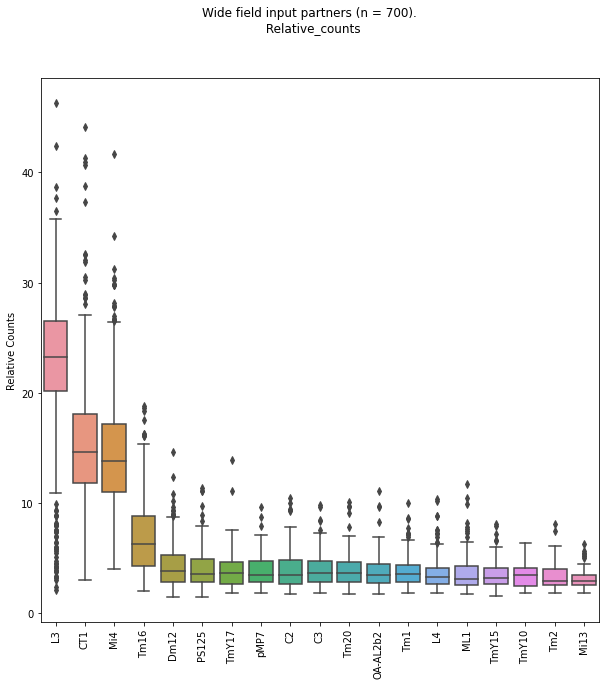

In [4]:
# Visualization
# Adjust subplot spacing and rotate x-axis labels
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)


major_inputs_data = filtered_data_df
#major_inputs_data = filtered_data_df[['L3', 'Mi4', 'CT1', 'Tm16', 'Dm12']]

sns.boxplot(data=major_inputs_data[major_inputs_data.mean().sort_values(ascending = False).index], ax=axs)
axs.set_ylabel('Relative Counts')
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)  # Rotate x-axis labels   

fig.suptitle(f'Wide field input partners (n = {number_of_columns}). \n {_sheet_name}')
plt.show()

## Anatomical RF size analysis

In [49]:
#For analysis purposes
min_desired_count = 3 # minimun desired number of contacts between pre and post neurons to be considered
single_column_diameter = 11.2 # in um (measured in FlyWire)
single_column_area = 100 # in um^2 (Assumed column as circle)

#For plotting purposes
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Processed-data'
fig_save_path = os.path.join(dataPath,"Figures")
save_figures = True

#General style
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}
axes = {'labelsize': 12, 'titlesize': 12}
ticks = {'labelsize': 10}
legend = {'fontsize': 8}
plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('xtick', **ticks)
plt.rc('ytick', **ticks)

#Saving text for pdfs in a proper way
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# For plotting purposes

hemisphere = 'R' # 'R', 'L'
neuropile_mesh = 'ME_L'
mesh_azim = 16# -18 for ME_R, 16 for ME_L
mesh_elev = -50 # -148 for ME_R, -50 for ME_L

Consider updating your ids in the original pre-neuron data set:


Updating:   0%|          | 0/110 [00:00<?, ?it/s]

,old_id,new_id,confidence,changed
8,720575940633681235,720575940633782436,1.00,True
9,720575940627971709,720575940621626560,1.00,True
18,720575940625057515,720575940633605663,1.00,True
20,720575940614311661,720575940639070554,1.00,True
29,720575940612811925,720575940640957016,1.00,True
33,720575940618740507,720575940622146470,1.00,True
39,720575940631099708,720575940633977645,1.00,True
46,720575940629488646,720575940615956118,1.00,True
55,720575940622687220,720575940630032144,1.00,True
67,720575940606569318,720575940628822088,1.00,True


Consider updating your ids in the original post neuron data set:


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

,old_id,new_id,confidence,changed
488,720575940616417653,720575940608436914,0.98,True
651,720575940639208169,720575940618614969,0.98,True


Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Quick visualization of presynaptic partner weight


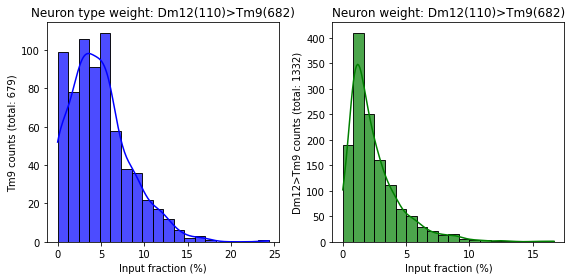

Pre-post match example after min syn fiter:


,post_pt_root_id,pre_pt_root_id,pre_syn_count
0,720575940600084489,720575940620506704,3
1,720575940600084489,720575940622432895,3
2,720575940600084489,720575940633977645,8
3,720575940602880736,720575940612534641,3
4,720575940602880736,720575940619165509,3


Fetching synapses:   0%|          | 0/16 [00:00<?, ?it/s]

Calculating spatial span


In [3]:
#############################################################################################
########## Matching all presynaptic cell ids connecting to each postsynaptic cell ###########


## Loading information  from excel files
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Excels\drive-data-sets\database'
date = '20230912'
pre_neuron_type = 'Dm12'
post_neuron_type = 'Tm9'
fileName_post = f'{post_neuron_type} proofreadings.xlsx'
filePath_post = os.path.join(dataPath,fileName_post)
fileName_pre = f'{pre_neuron_type} proofreadings.xlsx'
filePath_pre = os.path.join(dataPath,fileName_pre)

#Loading file as DataFrame
post_df = pd.read_excel(filePath_post)
pre_df = pd.read_excel(filePath_pre)

## Filtering data
# Selecting the R optic lobe IDs
R_pre_df = pre_df[pre_df['hemisphere'] == hemisphere].copy()
R_post_df = post_df[post_df['hemisphere'] == hemisphere].copy()
# Selecting the backbone proofread IDs
R_post_df = R_post_df[R_post_df['backbone proofread (Y/N)'] == 'Y'].copy()
#R_post_df = R_post_df[R_post_df['patch_id'] == 'D']
# Selecting presynaptic cells ids
pre_ids = R_pre_df['Updated_seg_id'].tolist()

# Quick updates
# Updating presynaptic neurons if they are not up-to-date
if not np.unique(flywire.is_latest_root(pre_ids))[0]: #if not up-to-date
    print('Consider updating your ids in the original pre-neuron data set:')
    pre_ids_update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    up_to_date_pre_ids = pre_ids_update_df['new_id'].tolist()
    display(pre_ids_update_df[pre_ids_update_df['changed'] == True])
else:
    up_to_date_pre_ids = [int(x) for x in pre_ids]
    print('All pre ids were up to date')
    

    ## Getting postsynaptic side ID
post_ids = R_post_df['Updated_seg_id'].tolist()

## Updating postsynaptic neurons if they are not up-to-date
if not np.unique(flywire.is_latest_root(post_ids))[0]: # if not up-to-date
    print('Consider updating your ids in the original post neuron data set:')
    #Updating the IDs via Fafbseg
    post_ids_update_df = flywire.update_ids(post_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    up_to_date_post_ids = post_ids_update_df['new_id']
    display(post_ids_update_df[post_ids_update_df['confidence'] < 1])
else:
    up_to_date_post_ids = [int(x) for x in post_ids]
    print('All post ids were up to date')
    

## Doing the pre to post match
pre_post_counts, post_inputs = match_all_pre_to_single_post(up_to_date_post_ids, up_to_date_pre_ids, neuropile_mesh) 

#############################################################################################
#### Quick visualization of presynaptic partner weight to postsynaptoc cell of interest ####

## Data analysis
neuron_weight_df, rel_neuron_type_weight = calculate_neuron_weights(pre_post_counts, post_inputs, 
                                                                    up_to_date_pre_ids, min_desired_count)

## Plot

# Calculate the percentage values
rel_neuron_type_weight_percent = [x * 100 for x in rel_neuron_type_weight] 
rel_neuron_weight_percent = [x * 100 for x in neuron_weight_df['rel_weight']] 

# Create subplots for each dimension using Seaborn
print('Quick visualization of presynaptic partner weight')
plt.figure(figsize=(12, 4))

plt.subplot(131)  # 1 row, 3 columns, 1st subplot
sns.histplot(rel_neuron_type_weight_percent, bins=20, color='blue', alpha=0.7, kde=True)
plt.title(f'Neuron type weight: {pre_neuron_type}({len(pre_ids)})>{post_neuron_type}({len(post_ids)})')
plt.xlabel('Input fraction (%)')  # Update the x-axis label
plt.ylabel(f'{post_neuron_type} counts (total: {len(rel_neuron_type_weight_percent)})')  # Update the x-axis label

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
sns.histplot(rel_neuron_weight_percent, bins=20, color='green', alpha=0.7, kde=True)
plt.title(f'Neuron weight: {pre_neuron_type}({len(pre_ids)})>{post_neuron_type}({len(post_ids)})')
plt.xlabel('Input fraction (%)')  # Update the x-axis label
plt.ylabel(f'{pre_neuron_type}>{post_neuron_type} counts (total: {len(rel_neuron_weight_percent)})')  # Update the x-axis label

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


#############################################################################################
## Analysis f spatial span of preynaptic inputs to single, unicolumnar, postsynaptic cells ##

# Synaptic counts filter
pre_post_counts = pre_post_counts[pre_post_counts['pre_syn_count']>=min_desired_count].copy()
print('Pre-post match example after min syn fiter:')
display(pre_post_counts.head())

## Geeting information for all pre cells 
pre_ls = pre_post_counts['pre_pt_root_id'].tolist() # all postsynaptic neurons

# Fetch the inputs from presynaptic cells
#TODO change "pre_inputs" to "pre_connectivity" (which includes inputs and outputs)
pre_inputs = flywire.synapses.fetch_synapses(pre_ls, pre=True, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

# Filtering: keeping only synapses in the medulla
pre_inputs = pre_inputs[pre_inputs['neuropil'] == neuropile_mesh].copy()
len(pre_inputs)

#Combining pre- and postsynpases XYZ values in single columns
combine_xyz(pre_inputs) # Function that does the operation

## Quantificatino of the spatial span
spatial_span_df, individual_spatial_span_df = calculate_spatial_span(up_to_date_post_ids, up_to_date_pre_ids, post_ids_update_df, R_post_df, post_inputs, pre_post_counts, pre_inputs, single_column_area, single_column_diameter)



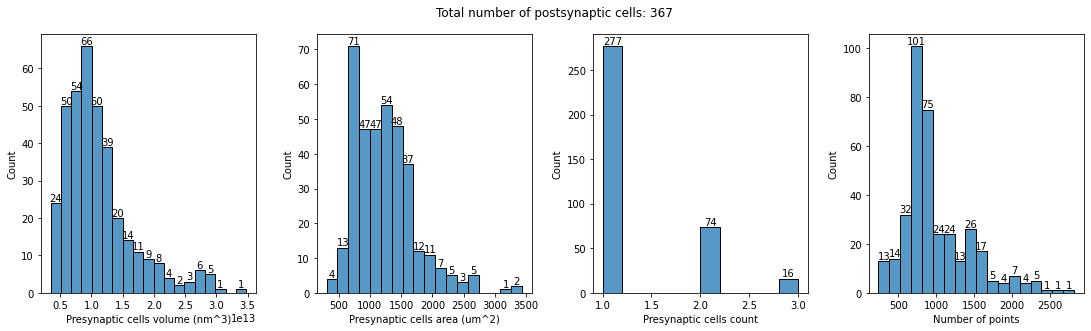

In [4]:
################################################################################################
#################    Brief spatial span statistics visualization with seaborn   ################

# Data
_data = spatial_span_df.copy()
#_data = _data[_data['Pre_count'] == 1.0] # Filtering in columns wiht single presynaptic partner

# Plot
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (40*cm, 12*cm))
fig.tight_layout(pad=3)
fig.suptitle(f"Total number of postsynaptic cells: {len(_data [~np.isnan(_data['Area'])])}")

# Plot histograms and annotate bars in each subplot
histograms = [_data['Volume'], _data['Area'], _data['Pre_count'],_data['Num_pre_sites']]
subplot_labels = ['Presynaptic cells volume (nm^3)', 'Presynaptic cells area (um^2)', 'Presynaptic cells count', 'Number of points']


for i, data in enumerate(histograms):
    sns.histplot(data, ax=axs[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel(subplot_labels[i])
    
    # Annotate the bars with counts for bars with height > 0
    for p in axs[i].patches:
        if p.get_height() > 0:
            axs[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

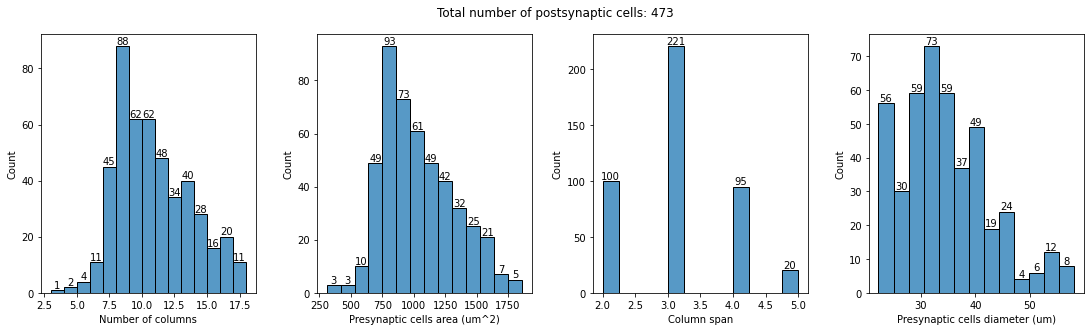

In [5]:
################################################################################################
#################    Brief spatial span statistics visualization with seaborn   ################

# Plot
filter_ouliers = True
cm = 1/2.54  # centimeters in inches

# Data
_data = individual_spatial_span_df.copy()

#Outlier filter
if filter_ouliers:
    _data = replace_outliers_with_nan(_data, multiplier=1.5)



fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (40*cm, 12*cm))
fig.tight_layout(pad=3)
fig.suptitle(f"Total number of postsynaptic cells: {len(_data [~np.isnan(_data['Area'])])}")

# Plot histograms and annotate bars in each subplot
histograms = [_data['Num_columns'], _data['Area'], _data['Column_span'],_data['Diameter']]
subplot_labels = ['Number of columns', 'Presynaptic cells area (um^2)', 'Column span', 'Presynaptic cells diameter (um)']
histograms_bin_width = [None,None,None,None]

for i, data in enumerate(histograms):
    sns.histplot(data,binwidth=histograms_bin_width[i], ax=axs[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel(subplot_labels[i])
    
    # Annotate the bars with counts for bars with height > 0
    for p in axs[i].patches:
        if p.get_height() > 0:
            axs[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

In [64]:
########## Looping across all presynaptic cell types


#############################################################################################
########## Matching all presynaptic cell ids connecting to each postsynaptic cell ###########

pre_neuron_type_ls = ['L3','Mi4','L4','Tm16','Dm12','C2','C3','Mi13','Tm1','Tm20','TmY10','TmY15','TmY17'] # add 


spatial_span_df_dict = {}
individual_spatial_span_df_dict = {}

for pre_neuron_type in pre_neuron_type_ls:
    print(f'Analyzing {pre_neuron_type}')

    ## Loading information  from excel files
    PC_disc = 'E'
    dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Excels\drive-data-sets\database'
    date = '20230912'
    post_neuron_type = 'Tm9'
    fileName_post = f'{post_neuron_type} proofreadings.xlsx'
    filePath_post = os.path.join(dataPath,fileName_post)
    fileName_pre = f'{pre_neuron_type} proofreadings.xlsx'
    filePath_pre = os.path.join(dataPath,fileName_pre)

    #Loading file as DataFrame
    post_df = pd.read_excel(filePath_post)
    pre_df = pd.read_excel(filePath_pre)

    ## Filtering data
    # Selecting the R optic lobe IDs
    R_pre_df = pre_df[pre_df['hemisphere'] == hemisphere].copy()
    R_post_df = post_df[post_df['hemisphere'] == hemisphere].copy()
    # Selecting the backbone proofread IDs
    R_post_df = R_post_df[R_post_df['backbone proofread (Y/N)'] == 'Y'].copy()
    R_pre_df = R_pre_df[R_pre_df['backbone proofread (Y/N)'] == 'Y'].copy()
    # Selecting presynaptic cells ids
    pre_ids = R_pre_df['Updated_seg_id'].tolist()
    print(f'Number of neurons: {len( pre_ids)}')

    # Quick updates
    # Updating presynaptic neurons if they are not up-to-date
    if not np.unique(flywire.is_latest_root(pre_ids))[0]: #if not up-to-date
        print('Consider updating your ids in the original pre-neuron data set')
        pre_ids_update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        up_to_date_pre_ids = pre_ids_update_df['new_id'].tolist()
    else:
        up_to_date_pre_ids = [int(x) for x in pre_ids]
        print('All pre ids were up to date')


        ## Getting postsynaptic side ID
    post_ids = R_post_df['Updated_seg_id'].tolist()

    ## Updating postsynaptic neurons if they are not up-to-date
    if not np.unique(flywire.is_latest_root(post_ids))[0]: # if not up-to-date
        print('Consider updating your ids in the original post neuron data set')
        #Updating the IDs via Fafbseg
        post_ids_update_df = flywire.update_ids(post_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        up_to_date_post_ids = post_ids_update_df['new_id']
    else:
        up_to_date_post_ids = [int(x) for x in post_ids]
        print('All post ids were up to date')


    ## Doing the pre to post match
    pre_post_counts, post_inputs = match_all_pre_to_single_post(up_to_date_post_ids, up_to_date_pre_ids, neuropile_mesh) 

    #############################################################################################
    ## Analysis f spatial span of preynaptic inputs to single, unicolumnar, postsynaptic cells ##

    # Synaptic counts filter
    pre_post_counts = pre_post_counts[pre_post_counts['pre_syn_count']>=min_desired_count].copy()

    ## Geeting information for all pre cells 
    pre_ls = pre_post_counts['pre_pt_root_id'].tolist() # all postsynaptic neurons

    # Fetch the inputs from presynaptic cells
    #TODO change "pre_inputs" to "pre_connectivity" (which includes inputs and outputs)
    pre_inputs = flywire.synapses.fetch_synapses(pre_ls, pre=True, post=True, attach=True, 
                                                 min_score=50, clean=True, transmitters=False, 
                                                 neuropils=True, batch_size=30, 
                                                 dataset='production', progress=True,mat= "live")

    # Filtering: keeping only synapses in the medulla
    pre_inputs = pre_inputs[pre_inputs['neuropil'] == neuropile_mesh].copy()
    len(pre_inputs)

    #Combining pre- and postsynpases XYZ values in single columns
    combine_xyz(pre_inputs) # Function that does the operation

    ## Quantificatino of the spatial span
    spatial_span_df, individual_spatial_span_df = calculate_spatial_span(up_to_date_post_ids, up_to_date_pre_ids, post_ids_update_df, R_post_df, post_inputs, pre_post_counts, pre_inputs, single_column_area, single_column_diameter)
    spatial_span_df_dict[pre_neuron_type] = spatial_span_df
    individual_spatial_span_df_dict[pre_neuron_type] = individual_spatial_span_df
    
print('Analysis done.')
    

Analyzing L3
Number of neurons: 645
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/645 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/18 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Mi4
Number of neurons: 723
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/723 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Calculating spatial span
Analyzing L4
Number of neurons: 51
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/51 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Tm16
Number of neurons: 130
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/130 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/20 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Dm12
Number of neurons: 41
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/41 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating spatial span
Analyzing C2
Number of neurons: 135
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/135 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Calculating spatial span
Analyzing C3
Number of neurons: 678
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/678 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/9 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Mi13
Number of neurons: 365
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/365 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Tm1
Number of neurons: 742
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/742 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Tm20
Number of neurons: 636
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/636 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating spatial span
Analyzing TmY10
Number of neurons: 146
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/146 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating spatial span
Analyzing TmY15
Number of neurons: 111
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/111 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Calculating spatial span
Analyzing TmY17
Number of neurons: 154
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/154 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating spatial span
Analysis done.


In [67]:
# Combining all dataframes and discarding outliers

# Initialize an empty list to store DataFrames
dfs_list = []

# Iterate through the dictionary
for neuron, df in individual_spatial_span_df_dict.items():
    #Discard outliers
    df = replace_outliers_with_nan(df, multiplier=1.5)
    # Add 'neuron' column to the DataFrame
    df['neuron'] = neuron
    if len(df) < 10:
        continue
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate DataFrames in the list
combined_individual_spatial_span_df = pd.concat(dfs_list, ignore_index=True)


In [68]:
combined_individual_spatial_span_df["neuron"].unique()

array(['L3', 'Mi4', 'L4', 'Tm16', 'Dm12', 'C2', 'C3', 'Mi13', 'Tm1',
       'Tm20', 'TmY10', 'TmY17'], dtype=object)

L3


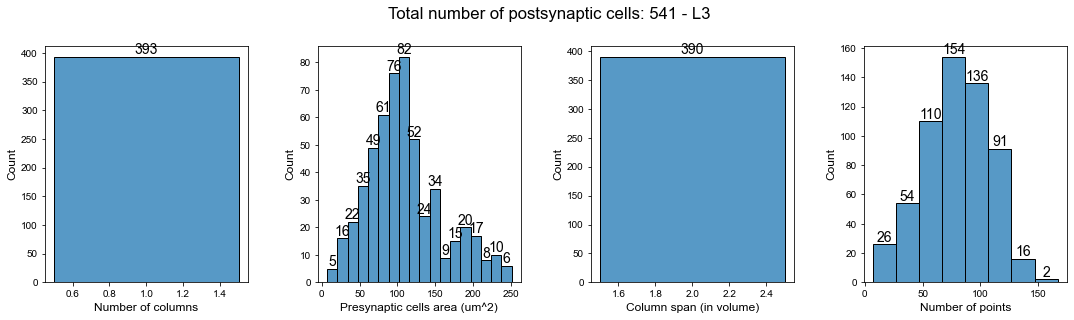

Mi4


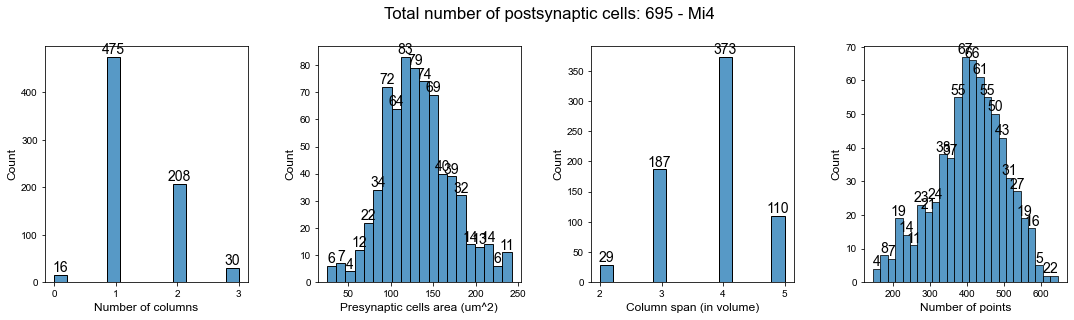

L4


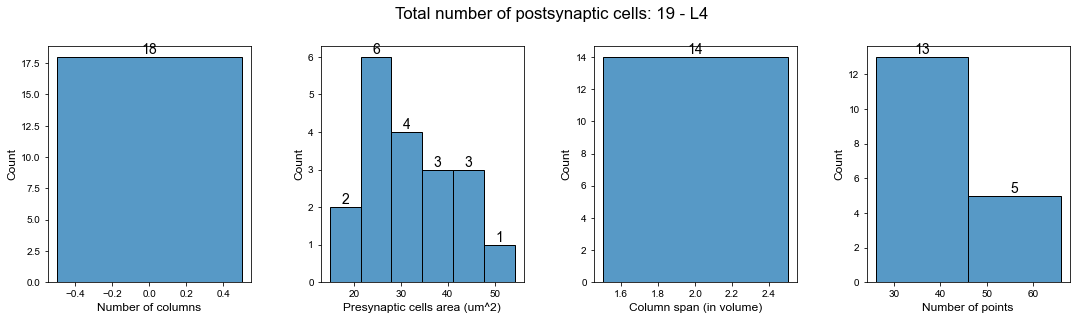

Tm16


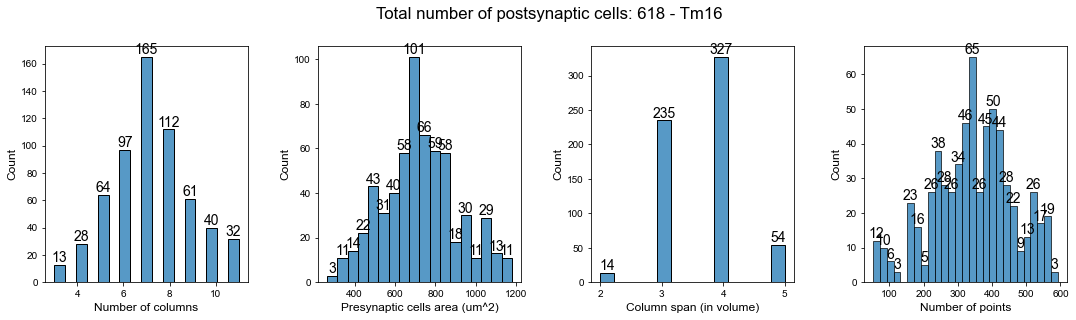

Dm12


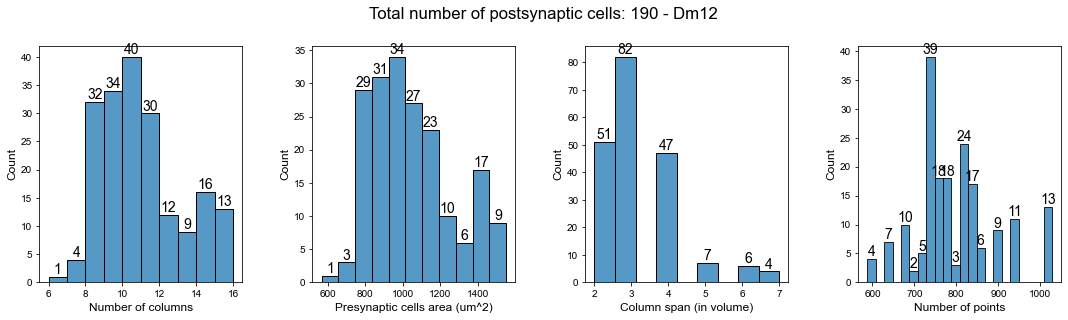

C2


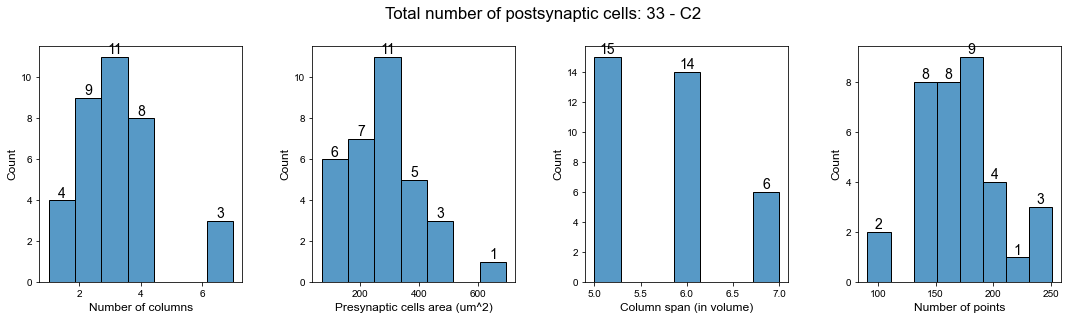

C3


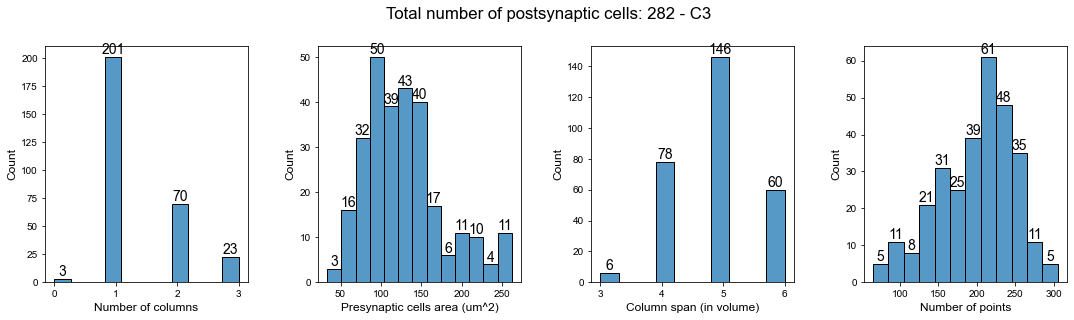

Mi13


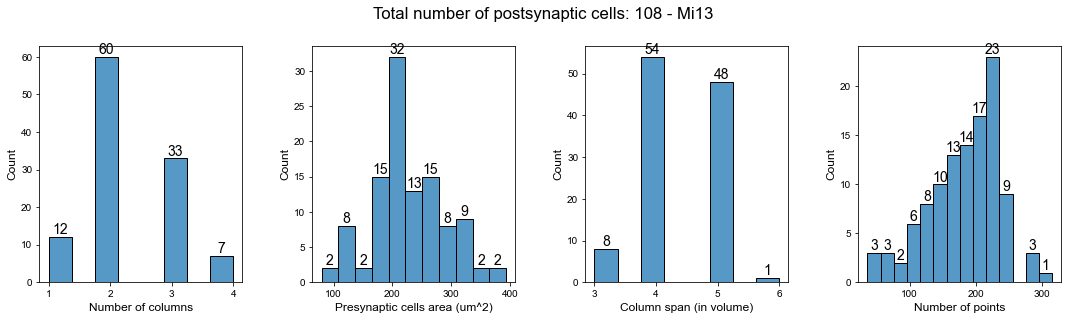

Tm1


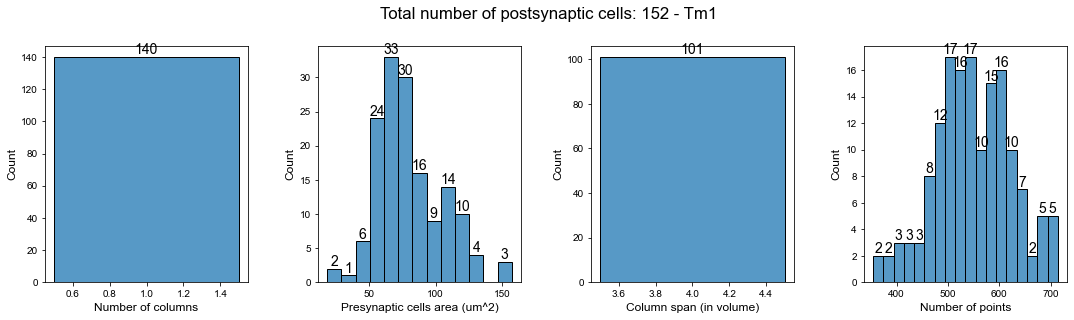

Tm20


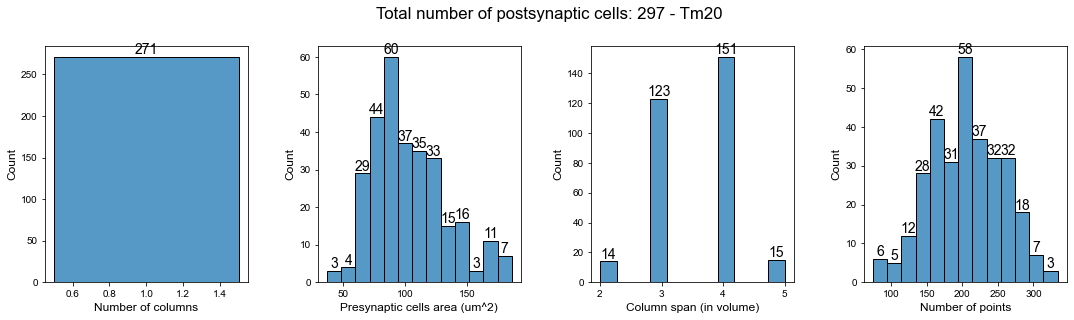

TmY10


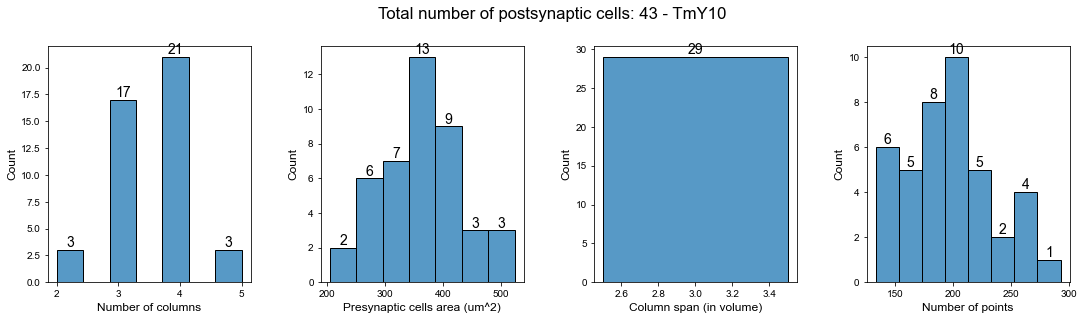

TmY15


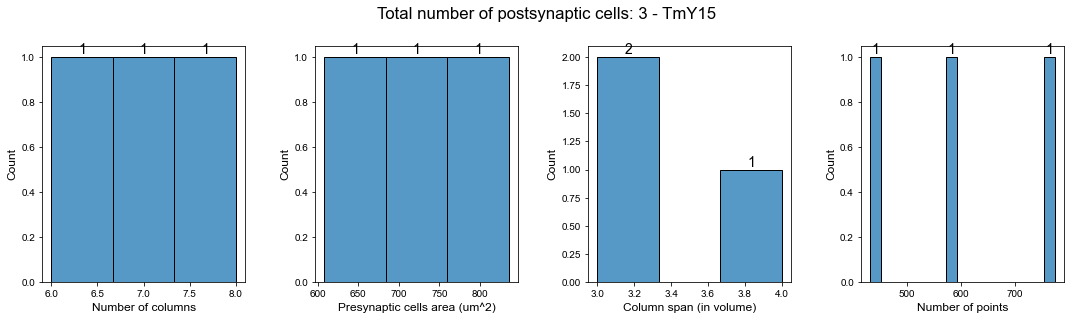

TmY17


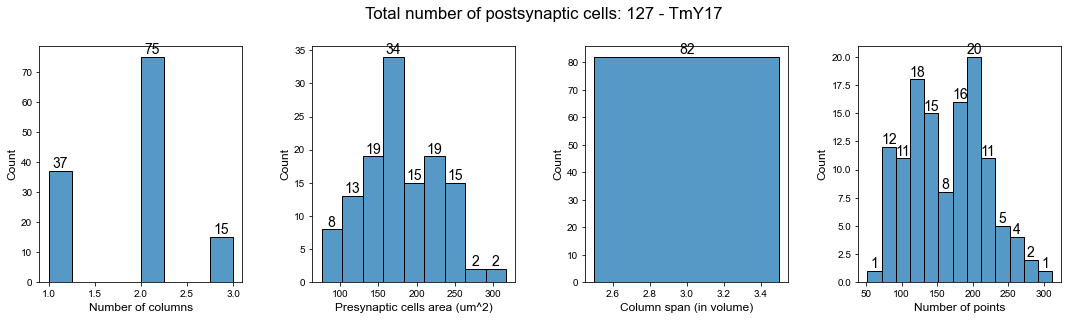

In [69]:
# Plotting individual histograms
cm = 1/2.54  # centimeters in inches
filter_ouliers = True

# Iterate over the keys and corresponding dataframes in the dictionary
for key, _data in individual_spatial_span_df_dict.items():
    print(key)
    
    #Outlier filter
    if filter_ouliers:
        _data = replace_outliers_with_nan(_data, multiplier=1.5)
        

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(40*cm, 12*cm))
    fig.tight_layout(pad=3)
    fig.suptitle(f"Total number of postsynaptic cells: {len(_data[~np.isnan(_data['Area'])])} - {key}")

    # Plot histograms and annotate bars in each subplot
    histograms = [_data['Num_columns'], _data['Area'], _data['Column_span'], _data['Num_pre_sites']]
    subplot_labels = ['Number of columns', 'Presynaptic cells area (um^2)', 'Column span (in volume)', 'Number of points']
    histograms_bin_width = [None,None,None,20]

    for i, data in enumerate(histograms):
        sns.histplot(data, binwidth=histograms_bin_width[i],  ax=axs[i])
        axs[i].set_ylabel('Count')
        axs[i].set_xlabel(subplot_labels[i])

        # Annotate the bars with counts for bars with height > 0
        for p in axs[i].patches:
            if p.get_height() > 0:
                axs[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

    plt.show()

L3
Mi4
L4
Tm16
Dm12
C2
C3
Mi13
Tm1
Tm20
TmY10
TmY17


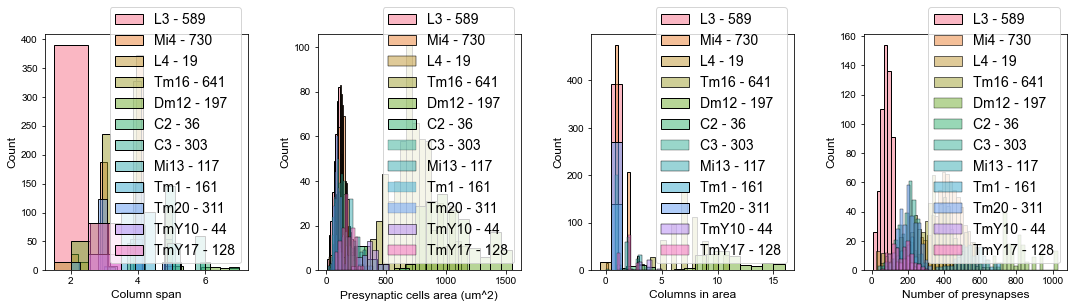

In [70]:
### Plotting histograms in same subplots

kde_only = False
discard_neurons = True
neuron_to_discard = ['TmY15']
_palette = sns.color_palette("husl", n_colors=len(individual_spatial_span_df_dict.keys()))

# Create a single figure and axis for all subplots
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(40*cm, 12*cm))
fig.tight_layout(pad=3)

# Define colors for each item in individual_spatial_span_df_dict
colors_dict = {key: _palette[i] for i, (key, _) in enumerate(individual_spatial_span_df_dict.items())}

# Iterate over the keys and corresponding dataframes in the dictionary
for key, _data in individual_spatial_span_df_dict.items():
    
    # Discard specified neurons
    if discard_neurons and key in neuron_to_discard:
        continue
    else:
        print(key)
        

    # Outlier filter
    if filter_ouliers:
        _data = replace_outliers_with_nan(_data, multiplier=1.5)

    # Plot histograms and/or KDE in the respective subplots
    histograms = [_data['Column_span'], _data['Area'], _data['Num_columns'], _data['Num_pre_sites']]
    subplot_labels = ['Column span', 'Presynaptic cells area (um^2)', 'Columns in area', 'Number of presynapses']
    histograms_bin_width = [None, None, None, 20]

    # Reset the index to avoid reindexing issues
    for i, data in enumerate(histograms):
        data = data.reset_index(drop=True)

        if kde_only:
            sns.kdeplot(data, ax=axs[i], label=f'{key}- {len(data)}', color=colors_dict[key])
            axs[i].set_ylabel('Density')
        else:
            sns.histplot(data, binwidth=histograms_bin_width[i], ax=axs[i], label=f'{key} - {len(data)}', color=colors_dict[key], kde=kde_only, alpha=0.5)
            axs[i].set_ylabel('Count')

        axs[i].set_xlabel(subplot_labels[i])

# Add legends to the subplots
for i in range(4):
    axs[i].legend()

# Show the figure
plt.show()

Significant difference between L3 and Mi4: p-value = 5.016597238548039e-21
Significant difference between L3 and L4: p-value = 4.2961464053632485e-10
Significant difference between L3 and Tm16: p-value = 3.115133304863072e-188
Significant difference between L3 and Dm12: p-value = 8.552824192243944e-92
Significant difference between L3 and C2: p-value = 1.6631572819486702e-14
Significant difference between L3 and C3: p-value = 2.186112337741752e-06
Significant difference between L3 and Mi13: p-value = 5.4375989993534715e-43
Significant difference between L3 and Tm1: p-value = 2.338041829943955e-11
Significant difference between L3 and TmY10: p-value = 9.320582441486408e-26
Significant difference between L3 and TmY17: p-value = 9.656734290465003e-32
Significant difference between Mi4 and L4: p-value = 1.4420874841054575e-11
Significant difference between Mi4 and Tm16: p-value = 1.9410782502754035e-213
Significant difference between Mi4 and Dm12: p-value = 2.0202345414930713e-97
Significa

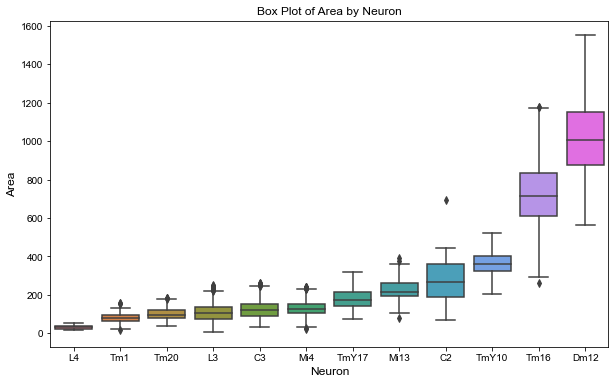

In [71]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Assuming your DataFrame is named 'combined_individual_spatial_span_df'
# Select the desired columns and assign them to a new DataFrame
selected_columns = ['Area', 'neuron']
selected_df = combined_individual_spatial_span_df[selected_columns]

# Drop rows with NaN values in the 'Area' column
selected_df = selected_df.dropna(subset=['Area'])

# Calculate the mean for each neuron category
mean_per_neuron = selected_df.groupby('neuron')['Area'].mean()

# Sort the neuron categories based on mean values in ascending order
sorted_neurons = mean_per_neuron.sort_values(ascending = True).index

# Plot the box plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(x='neuron', y='Area', data=selected_df, palette=_palette, order = sorted_neurons)

# Perform pairwise comparisons using Mann-Whitney U test
neuron_categories = selected_df['neuron'].unique()
p_values = []

for i in range(len(neuron_categories)):
    for j in range(i + 1, len(neuron_categories)):
        category1 = neuron_categories[i]
        category2 = neuron_categories[j]

        data1 = selected_df[selected_df['neuron'] == category1]['Area']
        data2 = selected_df[selected_df['neuron'] == category2]['Area']

        _, p_value = mannwhitneyu(data1, data2)
        p_values.append(p_value)

# Adjust p-values for multiple comparisons using Bonferroni correction
reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')

# Display significant comparisons
index = 0
for i in range(len(neuron_categories)):
    for j in range(i + 1, len(neuron_categories)):
        category1 = neuron_categories[i]
        category2 = neuron_categories[j]

        if reject[index]:
            print(f'Significant difference between {category1} and {category2}: p-value = {corrected_p_values[index]}')
        index += 1

# Add labels and title
plt.xlabel('Neuron')
plt.ylabel('Area')
plt.title('Box Plot of Area by Neuron')

# Show the plot
plt.show()


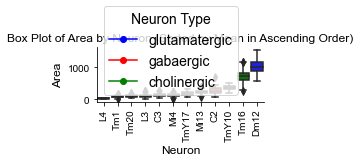

meta NOT subset; don't know how to subset; dropped


FIGURE: All neurons spatial span saved


In [72]:
# Define the neuron categories and their corresponding colors
glutamatergic_neurons = ['Mi13', 'Dm12']  # Choose blue
cholinergic_neurons = ['Tm1', 'Tm20', 'L3', 'L4', 'Mi4', 'TmY17', 'TmY10', 'Tm16']  # Choose green
gabaergic_neurons = ['C2', 'C3']  # Choose red

# Create the neuron_colors and legend_colors dictionaries
neuron_colors = {}
neuron_labels = {}
legend_colors = {}

# Assign colors to glutamatergic neurons and add labels
for neuron in glutamatergic_neurons:
    neuron_colors[neuron] = 'blue'
    neuron_labels[neuron] = 'glutamatergic'
    legend_colors['glutamatergic'] = 'blue'

# Assign colors to cholinergic neurons and add labels
for neuron in cholinergic_neurons:
    neuron_colors[neuron] = 'green'
    neuron_labels[neuron] = 'cholinergic'
    legend_colors['cholinergic'] = 'green'

# Assign colors to gabaergic neurons and add labels
for neuron in gabaergic_neurons:
    neuron_colors[neuron] = 'red'
    neuron_labels[neuron] = 'gabaergic'
    legend_colors['gabaergic'] = 'red'

# Select the desired columns and assign them to a new DataFrame
selected_columns = ['Area', 'neuron']
selected_df = combined_individual_spatial_span_df[selected_columns]

# Calculate the mean for each neuron category
mean_per_neuron = selected_df.groupby('neuron')['Area'].mean()

# Sort the neuron categories based on mean values in ascending order
sorted_neurons = mean_per_neuron.sort_values(ascending=True).index

# Create a list of colors and labels based on the neuron category of each data point
_palette = [neuron_colors[neuron] for neuron in sorted_neurons]
labels = [neuron_labels[neuron] for neuron in sorted_neurons]

# Create a figure handle
fig = plt.figure(figsize=(3, 1))  # Adjust the figure size as needed

# Plot the box plot with sorted order and custom palette
boxplot = sns.boxplot(x='neuron', y='Area', data=selected_df, palette=_palette, order=sorted_neurons)

# Remove left and top spines
boxplot.spines['right'].set_visible(False)
boxplot.spines['top'].set_visible(False)

# Rotate x-axis tick labels by 90 degrees
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)

# Add labels and title
plt.xlabel('Neuron')
plt.ylabel('Area')
plt.title('Box Plot of Area by Neuron (Sorted by Mean in Ascending Order)')

# Add legend with labels and matching colors
legend_labels = list(set(labels))  # Get unique labels
legend_handles = [plt.Line2D([0], [0], marker='o', color=legend_colors[label], markerfacecolor=legend_colors[label], label=label) for label in legend_labels]
plt.legend(handles=legend_handles, labels=legend_labels, title='Neuron Type')

# Show the plot
plt.show()

if save_figures:    
    figure_title = 'All-neurons-spatial-span-NT.pdf'
    fig.savefig(fig_save_path + figure_title)
    print('FIGURE: All neurons spatial span saved')

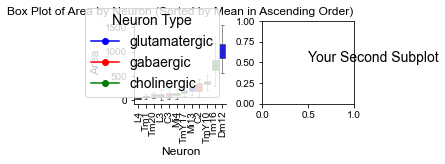

meta NOT subset; don't know how to subset; dropped


FIGURE: All neurons spatial span saved


In [79]:
# Define the neuron categories and their corresponding colors
glutamatergic_neurons = ['Mi13', 'Dm12']  # Choose blue
cholinergic_neurons = ['Tm1', 'Tm20', 'L3', 'L4', 'Mi4', 'TmY17', 'TmY10', 'Tm16']  # Choose green
gabaergic_neurons = ['C2', 'C3']  # Choose red

# Create the neuron_colors and legend_colors dictionaries
neuron_colors = {}
neuron_labels = {}
legend_colors = {}

# Assign colors to glutamatergic neurons and add labels
for neuron in glutamatergic_neurons:
    neuron_colors[neuron] = 'blue'
    neuron_labels[neuron] = 'glutamatergic'
    legend_colors['glutamatergic'] = 'blue'

# Assign colors to cholinergic neurons and add labels
for neuron in cholinergic_neurons:
    neuron_colors[neuron] = 'green'
    neuron_labels[neuron] = 'cholinergic'
    legend_colors['cholinergic'] = 'green'

# Assign colors to gabaergic neurons and add labels
for neuron in gabaergic_neurons:
    neuron_colors[neuron] = 'red'
    neuron_labels[neuron] = 'gabaergic'
    legend_colors['gabaergic'] = 'red'

# Select the desired columns and assign them to a new DataFrame
selected_columns = ['Area', 'neuron']
selected_df = combined_individual_spatial_span_df[selected_columns]

# Calculate the mean for each neuron category
mean_per_neuron = selected_df.groupby('neuron')['Area'].mean()

# Sort the neuron categories based on mean values in ascending order
sorted_neurons = mean_per_neuron.sort_values(ascending=True).index

# Create a list of colors and labels based on the neuron category of each data point
_palette = [neuron_colors[neuron] for neuron in sorted_neurons]
labels = [neuron_labels[neuron] for neuron in sorted_neurons]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Plot the box plot with sorted order and custom palette in the first subplot
boxplot = sns.boxplot(ax=axs[0], x='neuron', y='Area', data=selected_df, palette=_palette, 
                      order=sorted_neurons,linewidth=0.5,showfliers=False)

# Remove left and top spines
boxplot.spines['right'].set_visible(False)
boxplot.spines['top'].set_visible(False)

# Rotate x-axis tick labels by 90 degrees
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)

# Add labels and title to the first subplot
axs[0].set_xlabel('Neuron')
axs[0].set_ylabel('Area')
axs[0].set_title('Box Plot of Area by Neuron (Sorted by Mean in Ascending Order)')

# Add legend with labels and matching colors to the first subplot
legend_labels = list(set(labels))  # Get unique labels
legend_handles = [plt.Line2D([0], [0], marker='o', color=legend_colors[label], markerfacecolor=legend_colors[label], label=label) for label in legend_labels]
axs[0].legend(handles=legend_handles, labels=legend_labels, title='Neuron Type')

# Add the second subplot (you can customize this subplot as needed)
axs[1].text(0.5, 0.5, 'Your Second Subplot')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

if save_figures:    
    figure_title = '\All-neurons-spatial-span-NT.pdf'
    fig.savefig(fig_save_path + figure_title)
    print('FIGURE: All neurons spatial span saved')

Dm12


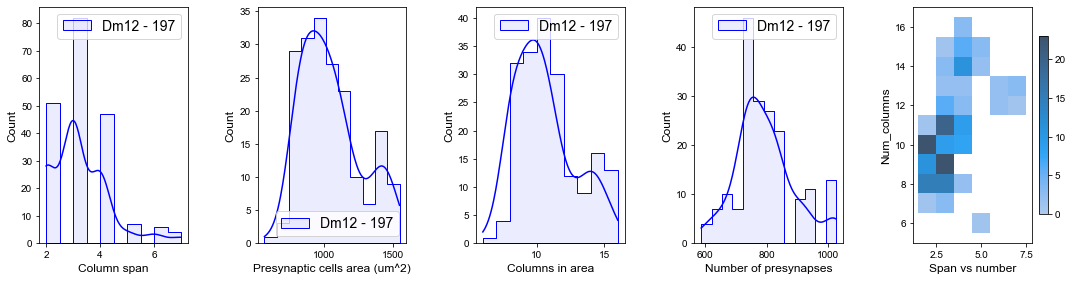

In [74]:
### Plotting histograms in same subplots:

kde_only = False
discard_neurons = True
neuron_to_discard = ['Mi4','C2','C3','Mi13','Tm1','Tm20','TmY15','TmY17','L3','L4', 'Tm16','TmY10']
_palette = sns.color_palette("husl", n_colors=len(individual_spatial_span_df_dict.keys()))

# Create a single figure and axis for all subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(40*cm, 12*cm))
fig.tight_layout(pad=3)

# Define colors for each item in individual_spatial_span_df_dict
colors_dict = {key: _palette[i] for i, (key, _) in enumerate(individual_spatial_span_df_dict.items())}

# Iterate over the keys and corresponding dataframes in the dictionary
for key, _data in individual_spatial_span_df_dict.items():
    
    # Discard specified neurons
    if discard_neurons and key in neuron_to_discard:
        continue
    else:
        print(key)
        

    # Outlier filter
    if filter_ouliers:
        _data = replace_outliers_with_nan(_data, multiplier=1.5)

    # Plot histograms and/or KDE in the respective subplots
    histograms = [_data['Column_span'], _data['Area'], _data['Num_columns'], _data['Num_pre_sites']]
    subplot_labels = ['Column span', 'Presynaptic cells area (um^2)', 'Columns in area', 'Number of presynapses']
    histograms_bin_width = [0.5, None, None, None]

    # Reset the index to avoid reindexing issues
    for i, data in enumerate(histograms):
        data = data.reset_index(drop=True)

        if kde_only:
            sns.kdeplot(data, ax=axs[i], label=f'{key}- {len(data)}', color="blue")
            axs[i].set_ylabel('Density')
        else:
            sns.histplot(data, binwidth=histograms_bin_width[i], ax=axs[i], label=f'{key} - {len(data)}', color='blue', alpha=0.075, 
                         kde = True,element="step", fill = True,stat="count")
            axs[i].set_ylabel('Count')

        axs[i].set_xlabel(subplot_labels[i])
    
    #Last subplot
    _data_reset_index = _data.reset_index()
    sns.histplot(
            _data_reset_index, x='Column_span', y='Num_columns',
            bins=30, discrete=(True, True), log_scale=(False, False),
            cbar=True, cbar_kws=dict(shrink=.75),ax=axs[4], label=f'{key} - {len(data)}')

    axs[4].set_xlabel('Span vs number')

# Add legends to the subplots
for i in range(4):
    axs[i].legend()

# Show the figure
plt.show()

Dm12


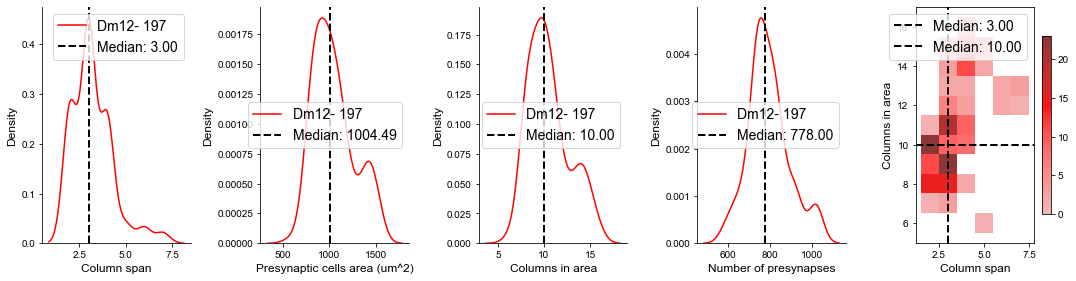

meta NOT subset; don't know how to subset; dropped


FIGURE: Spatial span saved


In [75]:
# Function to add mean and median lines to a subplot
def add_mean_median_lines(data, ax, color_mean, color_median, vertical=True):
    #mean_value = np.nanmean(data)
    median_value = np.nanmedian(data)
    
    if vertical:
        #ax.axvline(mean_value, color=color_mean, linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
        ax.axvline(median_value, color=color_median, linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
    else:
        #ax.axhline(mean_value, color=color_mean, linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
        ax.axhline(median_value, color=color_median, linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

### Plotting histograms in same subplots:

kde_only = True
discard_neurons = True
neuron_to_discard = ['Mi4','C2','C3','Mi13','Tm1','Tm20','TmY15','TmY17','L3','L4', 'Tm16','TmY10']
_palette = sns.color_palette("husl", n_colors=len(individual_spatial_span_df_dict.keys()))

# Create a single figure and axis for all subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(40*cm, 12*cm))
fig.tight_layout(pad=3)

# Define colors for each item in individual_spatial_span_df_dict
colors_dict = {key: _palette[i] for i, (key, _) in enumerate(individual_spatial_span_df_dict.items())}
color_rgb = (226 / 255, 26 / 255, 28 / 255)  # Red in RGB 
    
    
# Iterate over the keys and corresponding dataframes in the dictionary
for key, _data in individual_spatial_span_df_dict.items():
    
    # Discard specified neurons
    if discard_neurons and key in neuron_to_discard:
        continue
    else:
        print(key)
        

    # Outlier filter
    if filter_ouliers:
        _data = replace_outliers_with_nan(_data, multiplier=1.5)

    # Plot histograms and/or KDE in the respective subplots
    histograms = [_data['Column_span'], _data['Area'], _data['Num_columns'], _data['Num_pre_sites']]
    subplot_labels = ['Column span', 'Presynaptic cells area (um^2)', 'Columns in area', 'Number of presynapses']
    histograms_bin_width = [0.5, None, None, None]

    # Reset the index to avoid reindexing issues
    for i, data in enumerate(histograms):
        data = data.reset_index(drop=True)

        if kde_only:
            sns.kdeplot(data, ax=axs[i], label=f'{key}- {len(data)}', color="red")
            axs[i].set_ylabel('Density')
        else:
            sns.histplot(data, binwidth=histograms_bin_width[i], ax=axs[i], label=f'{key} - {len(data)}', color=color_rgb, alpha=0.075, 
                         kde=True, element="step", fill=True, stat="count")
            axs[i].set_ylabel('Count')

        axs[i].set_xlabel(subplot_labels[i])
        
        # Add mean and median lines
        add_mean_median_lines(data, axs[i], 'red', 'k')
        
        #Remove spines
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)

    # Last subplot
    _data_reset_index = _data.reset_index()
    sns.histplot(
    _data_reset_index, x='Column_span', y='Num_columns',
    bins=30, discrete=(True, True), log_scale=(False, False), color='red',
    cbar=True, cbar_kws=dict(shrink=.75), ax=axs[4], label=f'{key} - {len(data)}')
    axs[4].set_xlabel('Column span')
    axs[4].set_ylabel('Columns in area')

    
    # Add mean and median lines for x- and y-axis
    add_mean_median_lines(_data_reset_index['Column_span'], axs[4], 'red', 'k')
    add_mean_median_lines(_data_reset_index['Num_columns'], axs[4], 'red', 'k', vertical=False)

# Add legends to the subplots
for i in range(5):
    axs[i].legend()

# Show the figure
plt.show()

if save_figures:    
    figure_title = f'\Dm12-spatial-span-quantification.pdf'
    fig.savefig(fig_save_path+figure_title)
    print('FIGURE: Spatial span saved')

### Plotting a single case (for visualization and methods)

In [90]:
# Choosing a single presynaptic neuron

_data = individual_spatial_span_df_dict['Dm12'].copy()
single_data = _data[(_data['Area'] > 1041.2) & (_data['Area'] < 1050) & (_data['Column_span'] == 3)].copy()

single_data.columns

Index(['Volume', 'Area', 'Diameter', 'Hull', 'Pre_count', 'Pre_xyz',
       'Pre_center', 'Post_xyz', 'Area_zscore', 'Num_pre_sites', 'Num_columns',
       'Column_span'],
      dtype='object')

In [ ]:
# Create a 2D scatter plot for PCA-based projection

normal_vector = eigenvectors[:, [1, 2]]  # PC2 and PC3
projected_points = centered_points.dot(normal_vector)

#Calculate area
# Calculate the convex hull of the projected points
hull = ConvexHull(projected_points)

# Calculate the area of the convex hull
area = hull.volume  # Area is calculated as volume in 2D
area_um2 = area / 10**6

# Create a scatter plot of the PC1 and PC2 components
plt.scatter(projected_points[:, 0], projected_points[:, 1], marker='o', label='Projected PC2-PC3', c='red')

plt.plot(projected_points[hull.vertices,0], projected_points[hull.vertices,1], 'k--', lw=2)
#plt.plot(projected_points[hull.vertices[0],0], projected_points[hull.vertices[0],1], 'ko')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Area: {round(area_um2)} um^2')

# Show the plot
plt.legend()
plt.show()

In [ ]:
# Brief visualization for volumes
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.plot(pre_coords[:,0], pre_coords[:,1], pre_coords[:,2],'o')
ax.plot(pre_coords[hull.vertices,0], pre_coords[hull.vertices,1], pre_coords[hull.vertices,2], 'k--', lw=1)
#ax.plot(pre_coords[hull.vertices[0],0], pre_coords[hull.vertices[0],1],pre_coords[hull.vertices[0],2], 'ro')

OL_R = flywire.get_neuropil_volumes([neuropile_mesh]) 
navis.plot2d([OL_R], method='3d_complex', ax=ax)

ax.azim = mesh_azim
ax.elev = mesh_elev